In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Load CSV
df = pd.read_csv('productsales.csv')
df['date'] = pd.to_datetime(df['date'])

# Sort by date
df = df.sort_values(by='date')

# Aggregate total daily sales
daily_sales = df.groupby('date')['number_sold'].sum()

# Resample to daily frequency
daily_sales = daily_sales.asfreq('D').fillna(0)

# Set index name for clarity
daily_sales.index.name = 'date'

In [3]:
# Total sales by product type
product_sales = df.groupby('product_type')['number_sold'].sum().sort_values(ascending=False)

# Total sales by stall
stall_sales = df.groupby('stall_id')['number_sold'].sum().sort_values(ascending=False)

In [4]:
# Show basic structure of the DataFrame
print("DataFrame Info:\n")
print(df.info())

# Show statistical summary
print("\nDescriptive Statistics:\n")
print(df.describe())

# Show first few rows
print("\nFirst 5 Rows:\n")
print(df.head())

# Show missing values per column
print("\nMissing Values per Column:\n")
print(df.isnull().sum())

DataFrame Info:

<class 'pandas.core.frame.DataFrame'>
Index: 255640 entries, 0 to 255639
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   stall_id      255640 non-null  int64         
 1   product_type  255640 non-null  int64         
 2   date          255640 non-null  datetime64[ns]
 3   number_sold   255640 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 9.8 MB
None

Descriptive Statistics:

            stall_id   product_type                           date  \
count  255640.000000  255640.000000                         255640   
mean        3.000000       4.500000  2014-12-31 12:00:00.000000256   
min         0.000000       0.000000            2010-01-01 00:00:00   
25%         1.000000       2.000000            2012-07-01 18:00:00   
50%         3.000000       4.500000            2014-12-31 12:00:00   
75%         5.000000       7.000000            2017-07-01 06:00:

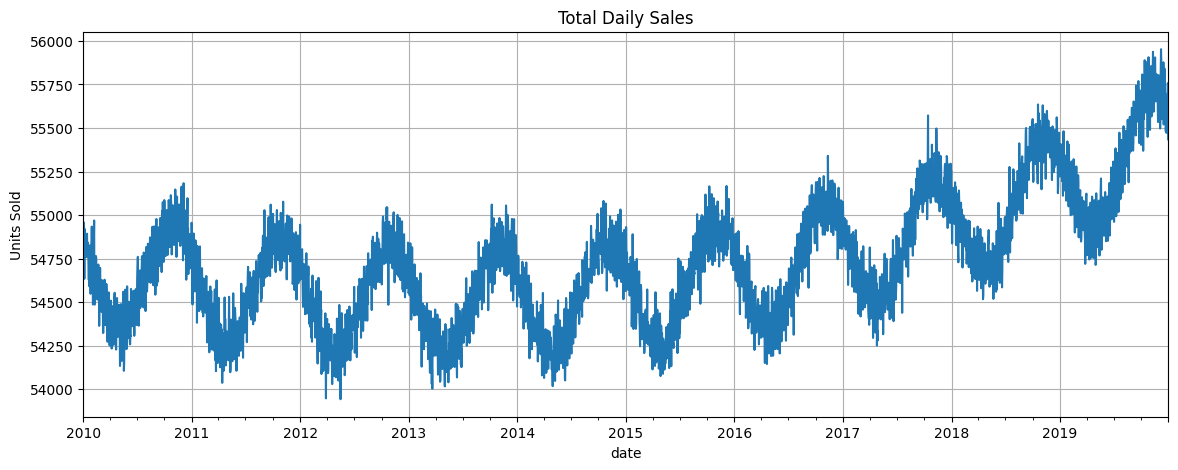

C:\Users\User001\AppData\Local\Temp\ipykernel_15508\1252106240.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=product_sales.index, y=product_sales.values, palette="Blues")


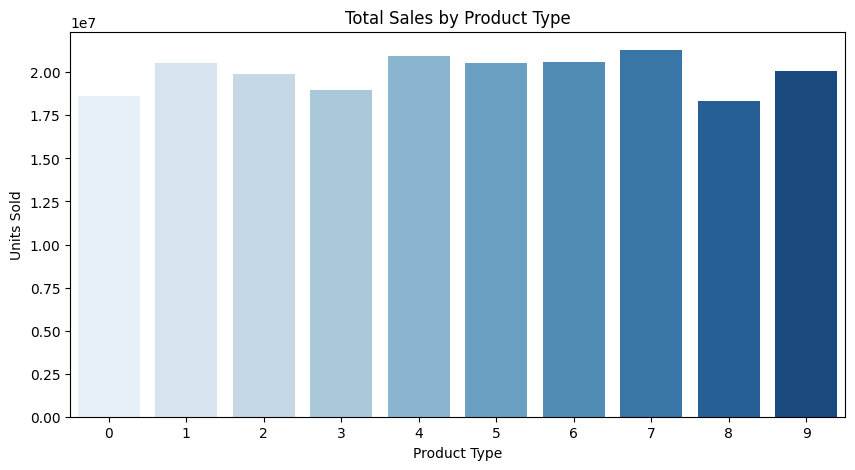

C:\Users\User001\AppData\Local\Temp\ipykernel_15508\1252106240.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=stall_sales.index, y=stall_sales.values, palette="Blues")


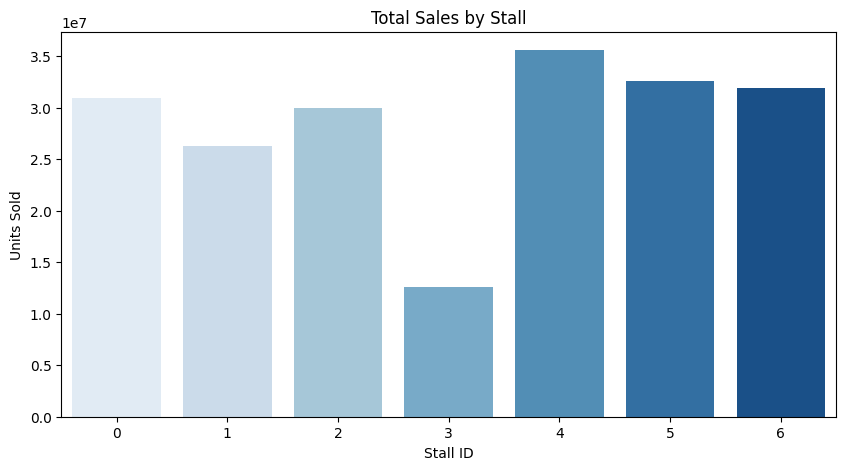

In [5]:
# Plot daily sales
plt.figure(figsize=(14,5))
daily_sales.plot()
plt.title('Total Daily Sales')
plt.ylabel('Units Sold')
plt.grid(True)
plt.show()

# Barplot: Product Types
plt.figure(figsize=(10, 5))
sns.barplot(x=product_sales.index, y=product_sales.values, palette="Blues")
plt.title("Total Sales by Product Type")
plt.xlabel("Product Type")
plt.ylabel("Units Sold")
plt.show()

# Barplot: Stall Sales
plt.figure(figsize=(10, 5))
sns.barplot(x=stall_sales.index, y=stall_sales.values, palette="Blues")
plt.title("Total Sales by Stall")
plt.xlabel("Stall ID")
plt.ylabel("Units Sold")
plt.show()

In [6]:
# Split into training (2010-2018) and test (2019)
train = daily_sales[:'2018-12-31']
test = daily_sales['2019-01-01':]

print(f"Training range: {train.index.min()} to {train.index.max()}")
print(f"Testing range: {test.index.min()} to {test.index.max()}")

Training range: 2010-01-01 00:00:00 to 2018-12-31 00:00:00
Testing range: 2019-01-01 00:00:00 to 2019-12-31 00:00:00


ADF Statistic: -2.532369713456092
p-value: 0.10779573173606699
Critical Value (1%): -3.4323593525669414
Critical Value (5%): -2.8624278120183573
Critical Value (10%): -2.567242601304915


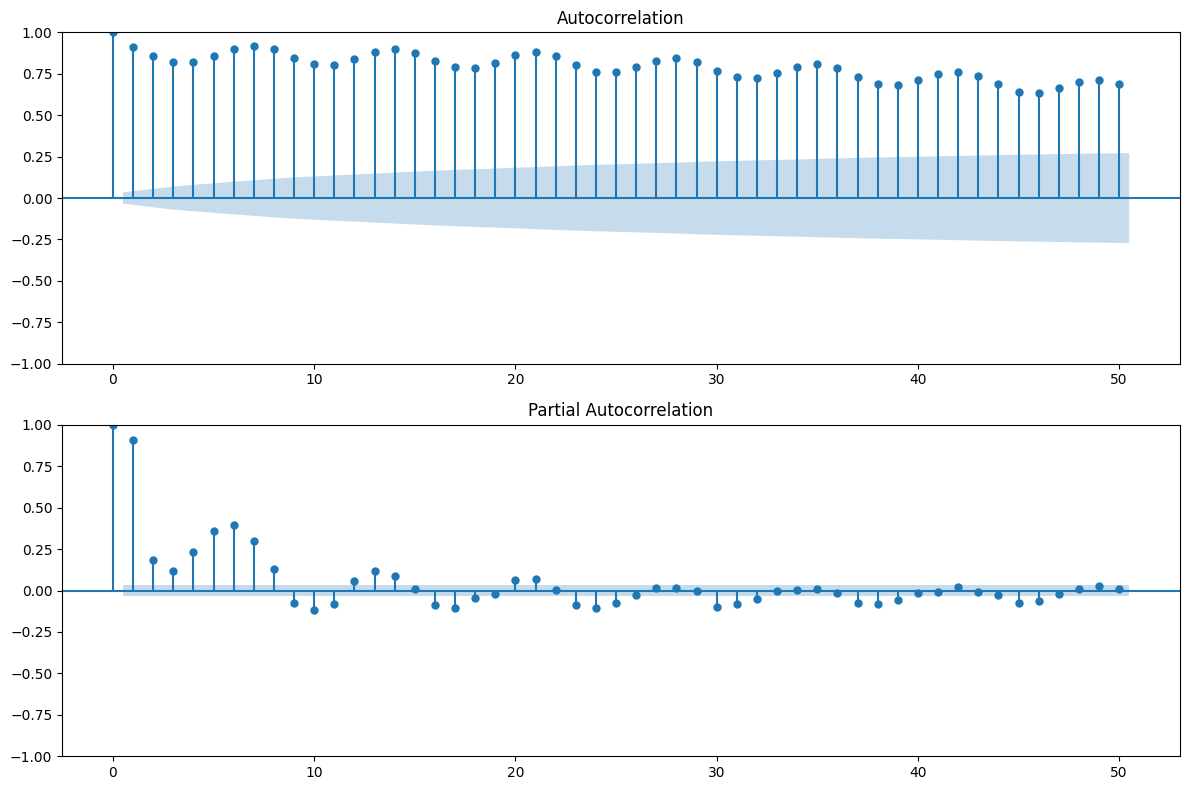

In [ ]:
# Stationarity Test
def test_stationarity(ts):
    result = adfuller(ts)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, val in result[4].items():
        print(f'Critical Value ({key}): {val}')

test_stationarity(train)

In [ ]:
# ACF & PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))
plot_acf(train, lags=50, ax=ax1)
plot_pacf(train, lags=50, ax=ax2)
plt.tight_layout()
plt.show()

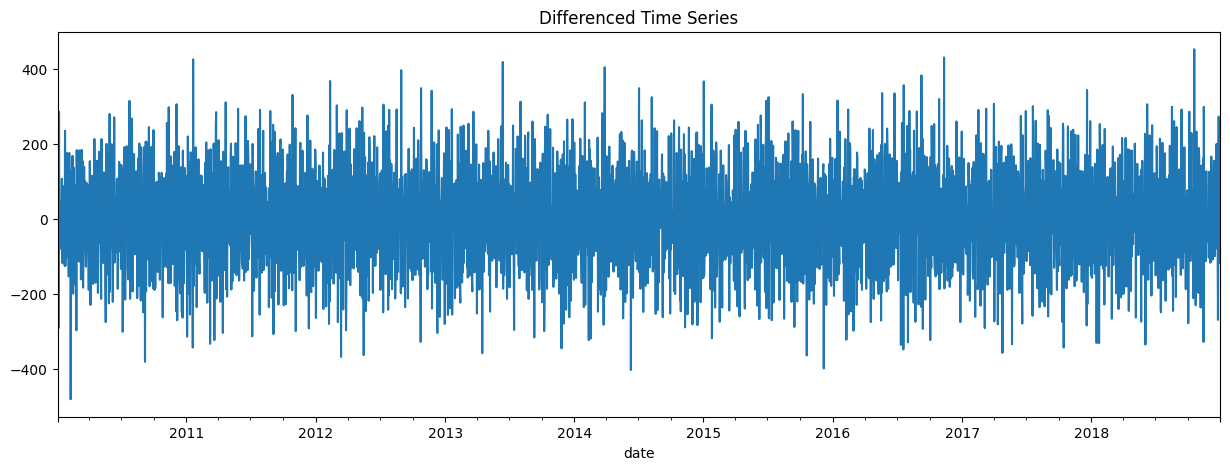

In [8]:
# Differencing to Achieve Stationarity
train_diff = train.diff().dropna()
train_diff.plot(figsize=(15,5), title="Differenced Time Series")
plt.show()

In [9]:
# ADF Test on Differenced Series
result_diff = adfuller(train_diff)
print('ADF Statistic (Differenced):', result_diff[0])
print('p-value:', result_diff[1])

ADF Statistic (Differenced): -7.113038701555264
p-value: 3.894249829400588e-10


In [10]:
# Fit ARIMA
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

# ARIMA Forecast
forecast_arima = model_fit.get_forecast(steps=len(test))
forecast_values = forecast_arima.predicted_mean
conf_int = forecast_arima.conf_int()
forecast_values.index = test.index 

c:\Users\User001\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:            number_sold   No. Observations:                 3287
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -20210.113
Date:                Thu, 03 Jul 2025   AIC                          40426.226
Time:                        23:56:22   BIC                          40444.518
Sample:                    01-01-2010   HQIC                         40432.775
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3288      0.021     15.683      0.000       0.288       0.370
ma.L1         -0.8905      0.010    -86.414      0.000      -0.911      -0.870
sigma2      1.278e+04    323.003     39.560      0.0

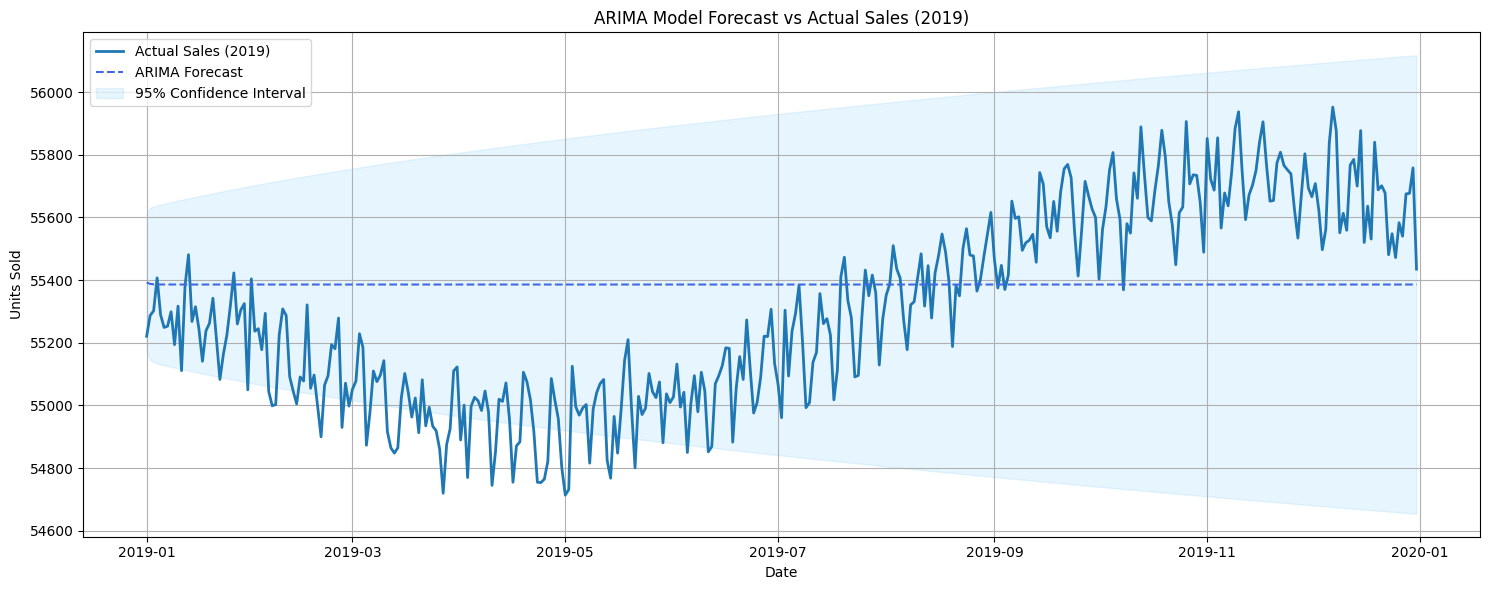

In [11]:
# Actual vs ARIMA Forecast with Confidence Intervals
plt.figure(figsize=(15,6))
plt.plot(test.index, test, label='Actual Sales (2019)', linewidth=2)
plt.plot(forecast_values.index, forecast_values, label='ARIMA Forecast', linestyle='--', color='royalblue')
plt.fill_between(forecast_values.index, 
                 conf_int.iloc[:, 0], 
                 conf_int.iloc[:, 1], 
                 color='lightskyblue', alpha=0.2, label='95% Confidence Interval')
plt.title('ARIMA Model Forecast vs Actual Sales (2019)')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

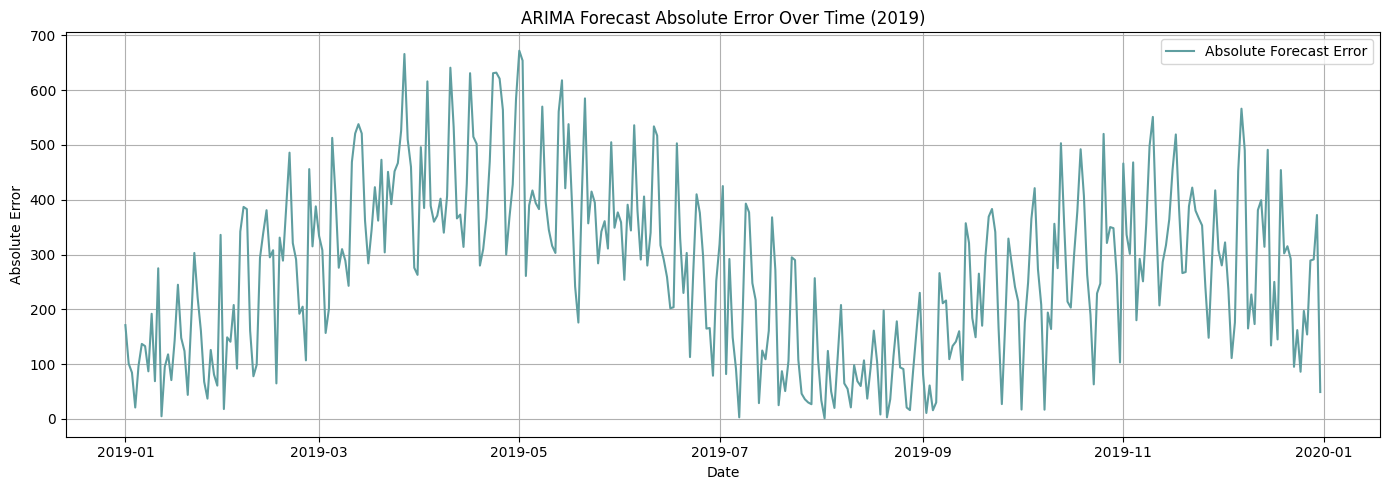

In [12]:
# Error Over Time (Absolute Error)
abs_error = np.abs(test - forecast_values)

plt.figure(figsize=(14,5))
plt.plot(abs_error.index, abs_error, label='Absolute Forecast Error', color='cadetblue')
plt.title('ARIMA Forecast Absolute Error Over Time (2019)')
plt.xlabel('Date')
plt.ylabel('Absolute Error')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# Evaluation Metrics
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mpe(y_true, y_pred):
    return np.mean((y_true - y_pred) / y_true) * 100

def minmax_error(y_true, y_pred):
    return 1 - np.mean(np.minimum(y_true, y_pred) / np.maximum(y_true, y_pred))

In [14]:
# Metrics for ARIMA
metrics = {
    'MAE': mean_absolute_error(test, forecast_values),
    'RMSE': np.sqrt(mean_squared_error(test, forecast_values)),
    'MAPE (%)': mape(test, forecast_values),
    'MPE (%)': mpe(test, forecast_values),
    'Correlation': np.corrcoef(test, forecast_values)[0,1],
    'Min-Max Error': minmax_error(test, forecast_values)
}

In [15]:
# Combine ARIMA and HW metrics into one DataFrame
metrics_df = pd.DataFrame({
    'Metric': list(metrics.keys()),
    'ARIMA': list(metrics.values()),
})

print("\nEvaluation Metrics:")
print(metrics_df.to_string(index=False))


Evaluation Metrics:
       Metric      ARIMA
          MAE 274.808423
         RMSE 316.617345
     MAPE (%)   0.497452
      MPE (%)  -0.151980
  Correlation  -0.013774
Min-Max Error   0.004952


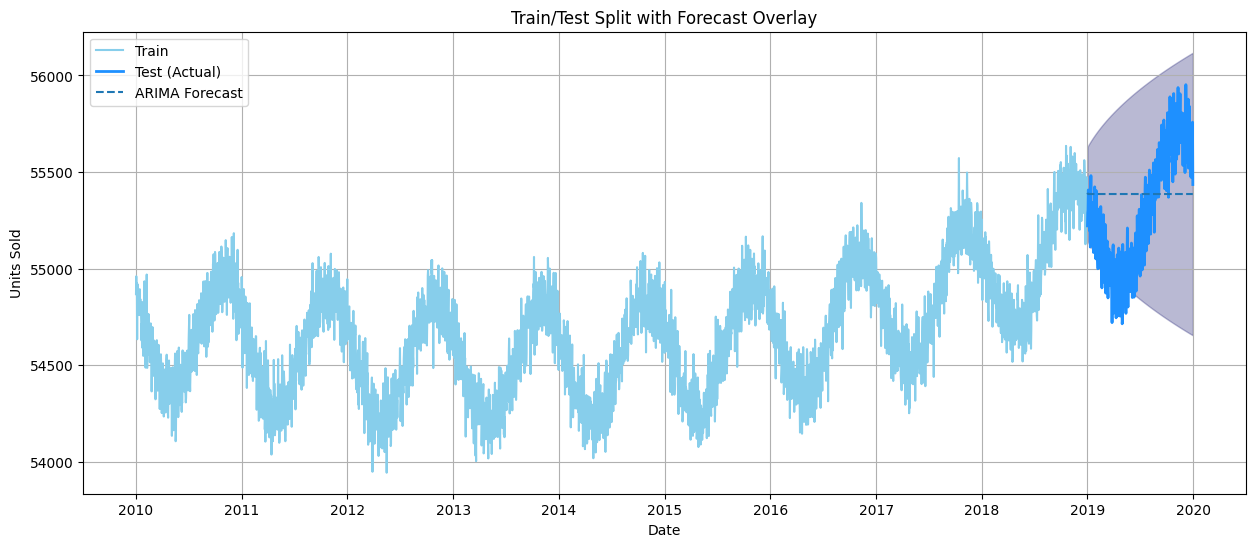

In [16]:
# Final Actual vs Forecast Plot
plt.figure(figsize=(15,6))
plt.plot(train.index, train, label='Train', color='skyblue')
plt.plot(test.index, test, label='Test (Actual)', linewidth=2, color='dodgerblue')
plt.plot(forecast_values.index, forecast_values, label='ARIMA Forecast', linestyle='--')
plt.fill_between(forecast_values.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='midnightblue', alpha=0.3)
plt.title("Train/Test Split with Forecast Overlay")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.legend()
plt.grid(True)
plt.show()

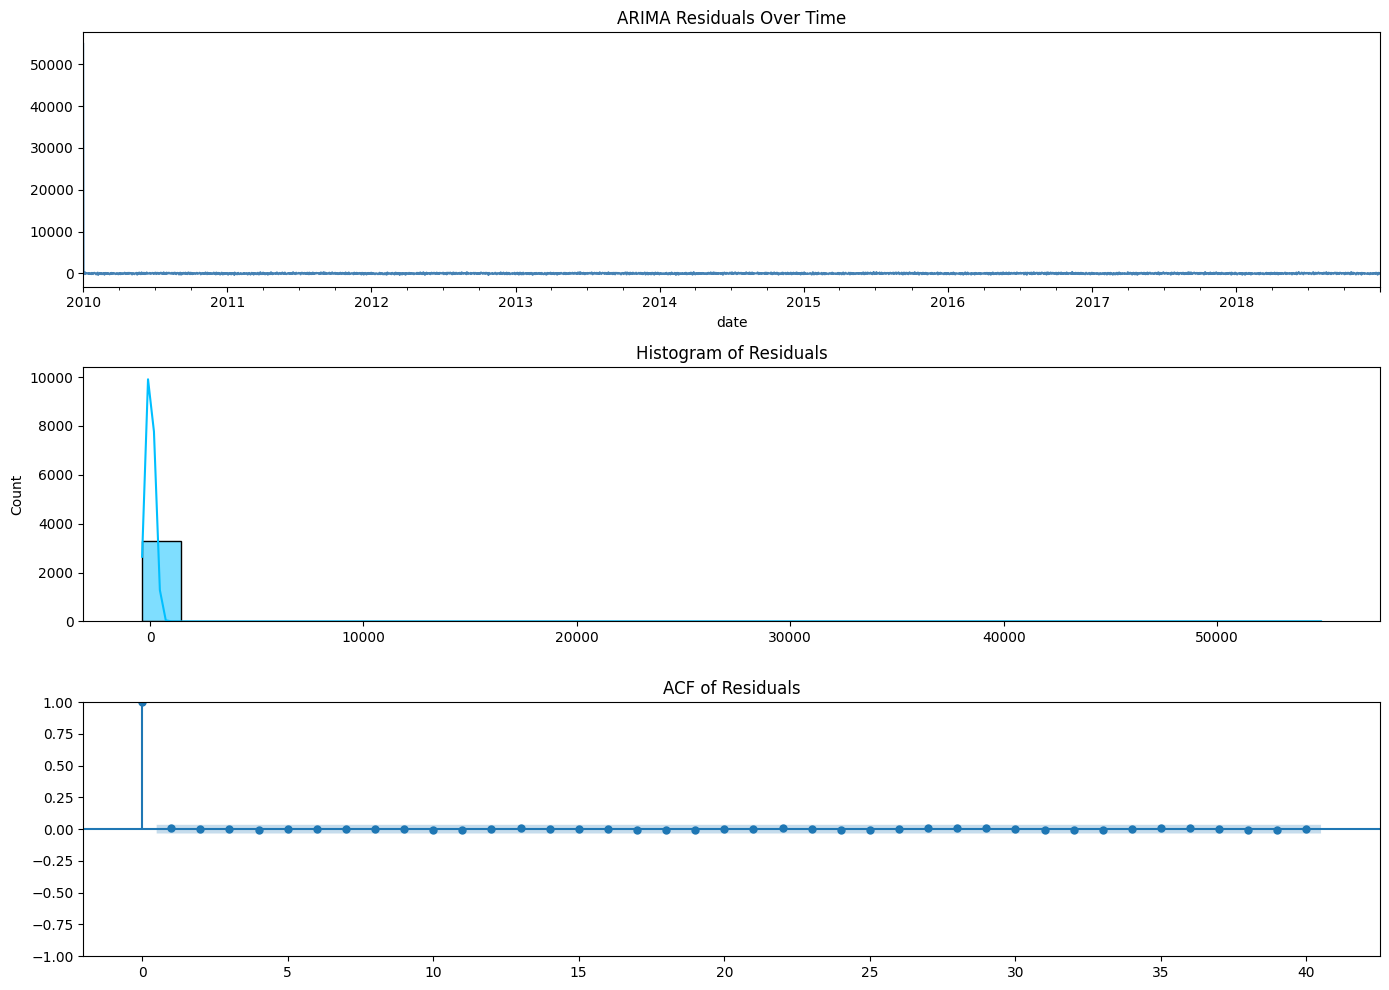

In [17]:
residuals = model_fit.resid

fig, ax = plt.subplots(3, 1, figsize=(14, 10))

# Residuals over time
residuals.plot(ax=ax[0], title="ARIMA Residuals Over Time", color='steelblue')

# Histogram of residuals
sns.histplot(residuals, bins=30, kde=True, ax=ax[1], color='deepskyblue')
ax[1].set_title("Histogram of Residuals")

# ACF plot of residuals
plot_acf(residuals, lags=40, ax=ax[2])
ax[2].set_title("ACF of Residuals")

plt.tight_layout()
plt.show()
